# 1. Собрать данные по дневным ценам активов (акций) и дневным объемам продаж на заданном фондовом рынке за указанный период. Добавить (если нет) данные по индексу рынка.

In [1]:
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials

**Скачал список компаний Франкфуртской биржи**

In [2]:
start_date = '2019-01-02'
end_date = '2020-01-01'

def download_ticker(ticker, start=start_date, end=end_date):
    return yf.download(ticker, start, end)

**Индекс DAX представляет собой главный индекс Франфуртской биржи.  Индекс вычисляется как среднее взвешенное по капитализации значение цен акций крупнейших акционерных компаний Германии (при этом капитализация рассчитывается лишь на основе акций, находящихся в свободном обращении). Индекс учитывает также полученные в виде дивидендов доходы по акциям, предполагая, что дивиденды реинвестируются в акцию, по которой был получен данный дивиденд. Таким образом, индекс отражает суммарный доход по капиталу.**

In [3]:
DAX_index = download_ticker('^GDAXI')
DAX_index.drop(['Open', 'High', 'Low', 'Close'], axis=1, inplace=True)
DAX_index

[*********************100%***********************]  1 of 1 completed


,Adj Close,Volume
Date,,
2019-01-02,10580.190430,79626700
2019-01-03,10416.660156,84733800
2019-01-04,10767.690430,95339500
2019-01-07,10747.809570,71151400
2019-01-08,10803.980469,93672200
...,...,...
2019-12-19,13211.959961,84018200
2019-12-20,13318.900391,170723200
2019-12-23,13300.980469,56215400


**Выкачал тикеры, удалил из датафрейма компании которые не скачались. Перекачивать не нужно, сохранено в бинарник.**

In [4]:
import pickle

In [5]:
companies_dump_file_name = 'companies.p'
tickers_dump_file_name = 'tickers.p'

**Следующая ячейка загружает обьекты из файлов в память**

In [6]:
companies_list = pickle.load(open(companies_dump_file_name, "rb"))
tickers = pickle.load(open(tickers_dump_file_name, "rb"))

In [7]:
companies_list.drop(['ISIN', 'Country' ,'Instrument Exchange'], axis=1, inplace=True)

In [8]:
for ticker in tickers:
    ticker.drop(['Open', 'High', 'Low', 'Close'], axis=1, inplace=True)

In [9]:
len(tickers)

108

In [10]:
tickers[0]

,Adj Close,Volume
Date,,
2019-01-02,62.470619,4549300
2019-01-03,61.614986,4562200
2019-01-04,62.461220,4825900
2019-01-07,65.517059,7630600
2019-01-08,65.451233,6756000
...,...,...
2019-12-24,124.720284,1643400
2019-12-26,125.050156,2197900
2019-12-27,125.360641,2233600


# 2. Преобразовать данные по ценам в данные по доходностям (используйте логарифмическую доходность). Вычислите оценки ожидаемых доходностей и стандартных отклонений и постройте «карту» активов в системе координат (σ, E).

**По взвешенной цене закрытия считаю логарифмические доходности за периоды.**

In [11]:
count = 0
for ticker in tickers:
    log_returns = []
    close_price = ticker['Adj Close']
    log_returns.append(None)
    for i in range(1, len(close_price)):
        log_return = (close_price[i] - close_price[i - 1]) / close_price[i - 1]
        log_returns.append(log_return)
    ticker['LogReturn'] = log_returns
    count += 1

In [12]:
tickers[0]

,Adj Close,Volume,LogReturn
Date,,,
2019-01-02,62.470619,4549300,NaN
2019-01-03,61.614986,4562200,-0.013697
2019-01-04,62.461220,4825900,0.013734
2019-01-07,65.517059,7630600,0.048924
2019-01-08,65.451233,6756000,-0.001005
...,...,...,...
2019-12-24,124.720284,1643400,0.001636
2019-12-26,125.050156,2197900,0.002645
2019-12-27,125.360641,2233600,0.002483


**Для каждого актива высчитываю логарифмическую доходность за год (по сумме доходностей за отдельные периоды), а также оценку доходности как среднее от доходностей за отдельные периоды.**

In [13]:
companies_list['Annual LogReturn'] = [tickers[i]['LogReturn'].sum() for i, row in companies_list.iterrows()]
companies_list['E'] = [tickers[i]['LogReturn'].mean() for i, row in companies_list.iterrows()]

**Риск - стандартное отклонение доходности**

In [14]:
companies_list['Risk'] = [tickers[i]['LogReturn'].std() for i, row in companies_list.iterrows()]

**В некоторых слишком мало наблюдений, удалил все где меньше 100 периодов.**

In [15]:
little_observations = []
for i in range(len(tickers)):
    if len(tickers[i]) < 100:
        little_observations.append(i)

In [16]:
little_observations

[8, 9, 10, 13, 14, 19, 23, 42, 43, 48, 60, 61, 67, 72, 89, 106]

In [17]:
companies_list = companies_list.drop(little_observations)

In [18]:
companies_list = companies_list.reset_index(drop=True)

**Итоговые данные с которыми можно работать:**

In [19]:
companies_list

,Ticker,Company,Sector,Subsector,Annual LogReturn,E,Risk
0,TGT,11 88 0 SOLUTIONS AG,Telecommunication,Telecommunication Services,0.741353,0.002954,0.020980
1,UUU,3U HOLDING AG,Industrial,Industrial Products & Services,-0.441075,-0.001757,0.041125
2,VSC,4SC AG,Pharma & Healthcare,Biotechnology,-0.271261,-0.001185,0.017601
3,ARL,AAREAL BANK AG,Banks,Mortgage Banks,0.468157,0.001865,0.034848
4,APM,"AD PEPPER MEDIA EO 0,05",Media,Advertising,0.192979,0.000769,0.037671
...,...,...,...,...,...,...,...
87,EQS,EQS GROUP AG NA O.N.,Software,IT-Services,0.004125,0.000018,0.026577
88,MUX,MUTARES KGAA NA O.N.,Financial Services,Private Equity & Venture Capital,-0.233334,-0.000930,0.036996
89,NTG,NABALTEC AG INH.,Industrial,Industrial Products & Services,0.008308,0.000033,0.012426
90,NUVA,NORATIS AG INH. O.N.,Financial Services,Real Estate,0.517704,0.002063,0.020158


In [20]:
import matplotlib.pyplot as plt

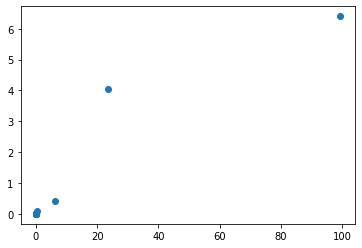

In [21]:
plt.scatter(companies_list['Risk'], companies_list['E'])

**Удалил выбросы**

In [22]:
for i, row in companies_list.iterrows():
    if row['Risk'] > 0.1:
        companies_list.drop(i, inplace=True)

Text(0, 0.5, 'E (Лог. доходность)')

<Figure size 720x720 with 0 Axes>

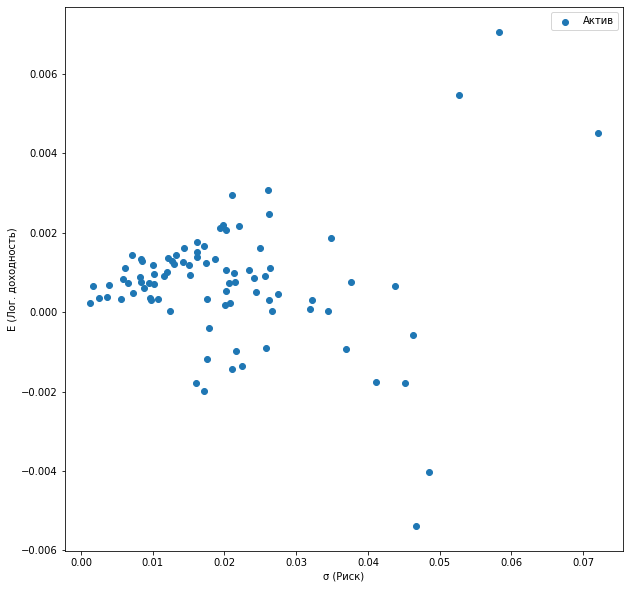

In [23]:
plt.figure(figsize=(10,10))
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(companies_list['Risk'], companies_list['E'], label='Актив')
ax.legend()
plt.xlabel('σ (Риск)')
plt.ylabel('E (Лог. доходность)')

# 3. Рассмотрите портфель с равными долями капитала и отметьте его на карте активов в системе координат (σ, E). Дайте характеристику этому портфелю.

In [24]:
balanced_E = companies_list['E'].mean()
balanced_Risk = companies_list['E'].std()
print('Сбалансированный портфель:\nE =', balanced_E, '\nσ =', balanced_Risk)

Сбалансированный портфель:
E = 0.0007227293321742406 
σ = 0.0016122208953505597


<Figure size 720x720 with 0 Axes>

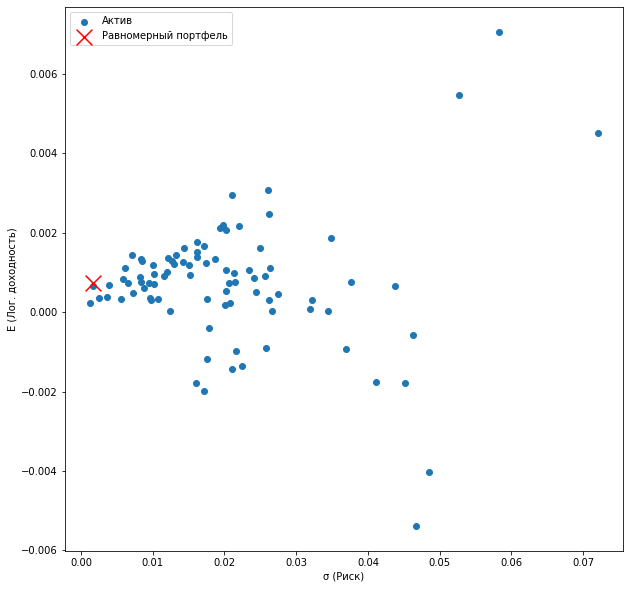

In [25]:
plt.figure(figsize=(10,10))
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(companies_list['Risk'], companies_list['E'], label='Актив')
ax.scatter([balanced_Risk], [balanced_E], marker='x', color='red', s=[250], label='Равномерный портфель')
ax.legend()
plt.xlabel('σ (Риск)')
plt.ylabel('E (Лог. доходность)')
plt.show()

# 4. Рассмотрите индекс рынка и отметьте его на карте активов в системе координат (σ,E). Дайте характеристику индексу рынка.

In [26]:
log_returns = []
close_price = DAX_index['Adj Close']
log_returns.append(None)
for i in range(1, len(close_price)):
    log_return = (close_price[i] - close_price[i - 1]) / close_price[i - 1]
    log_returns.append(log_return)
DAX_index['LogReturn'] = log_returns
DAX_index

,Adj Close,Volume,LogReturn
Date,,,
2019-01-02,10580.190430,79626700,NaN
2019-01-03,10416.660156,84733800,-0.015456
2019-01-04,10767.690430,95339500,0.033699
2019-01-07,10747.809570,71151400,-0.001846
2019-01-08,10803.980469,93672200,0.005226
...,...,...,...
2019-12-19,13211.959961,84018200,-0.000771
2019-12-20,13318.900391,170723200,0.008094
2019-12-23,13300.980469,56215400,-0.001345


In [27]:
dax_annual_log_return = DAX_index['LogReturn'].sum()
dax_E = DAX_index['LogReturn'].mean()
dax_Risk = DAX_index['LogReturn'].std()
print('Годовая логарифмическая доходность рынка по индексу DAX =', dax_annual_log_return)
print('Оценка логарифмическая доходности рынка по индексу DAX =', dax_E)
print('Оценка рынка по индексу DAX =', dax_Risk)

Годовая логарифмическая доходность рынка по индексу DAX = 0.2347641154811551
Оценка логарифмическая доходности рынка по индексу DAX = 0.0009390564619246205
Оценка рынка по индексу DAX = 0.00883293268285711


<Figure size 720x720 with 0 Axes>

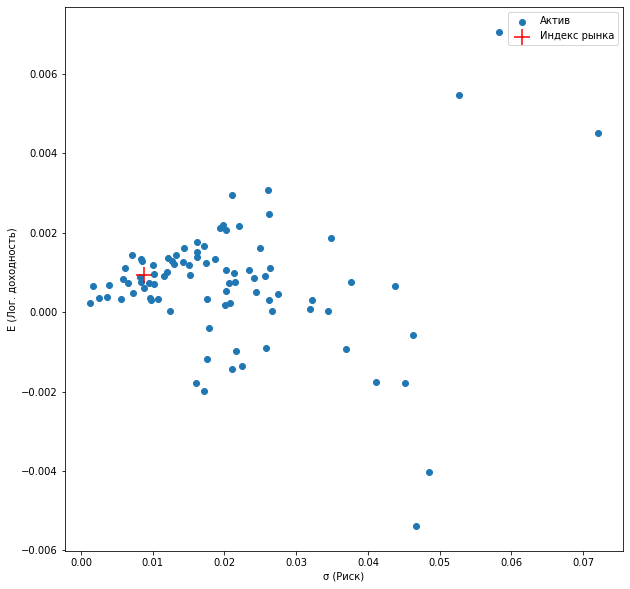

In [28]:
plt.figure(figsize=(10,10))
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(companies_list['Risk'], companies_list['E'], label='Актив')
ax.scatter([dax_Risk], [dax_E], marker='+', color='red', s=[250], label='Индекс рынка')
ax.legend()
plt.xlabel('σ (Риск)')
plt.ylabel('E (Лог. доходность)')
plt.show()

In [36]:
companies_list_csv = 'companies_list.csv'
companies_list.to_csv(companies_list_csv)

In [37]:
companies_list = pd.read_csv(companies_list_csv, index_col='index')
companies_list

,Ticker,Company,Sector,Subsector,Annual LogReturn,E,Risk
index,,,,,,,
0,TGT,11 88 0 SOLUTIONS AG,Telecommunication,Telecommunication Services,0.741353,0.002954,0.020980
1,UUU,3U HOLDING AG,Industrial,Industrial Products & Services,-0.441075,-0.001757,0.041125
2,VSC,4SC AG,Pharma & Healthcare,Biotechnology,-0.271261,-0.001185,0.017601
3,ARL,AAREAL BANK AG,Banks,Mortgage Banks,0.468157,0.001865,0.034848
4,APM,"AD PEPPER MEDIA EO 0,05",Media,Advertising,0.192979,0.000769,0.037671
...,...,...,...,...,...,...,...
87,EQS,EQS GROUP AG NA O.N.,Software,IT-Services,0.004125,0.000018,0.026577
88,MUX,MUTARES KGAA NA O.N.,Financial Services,Private Equity & Venture Capital,-0.233334,-0.000930,0.036996
89,NTG,NABALTEC AG INH.,Industrial,Industrial Products & Services,0.008308,0.000033,0.012426
